# EDA and Data Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df= pd.read_csv('CryptoWikiViewsPriceTrendsSince2018.csv') #Loading the data gathered in 'Scraper.ipynb'

In [4]:
df.head(3)

,date,Bitcoin_views,Ethereum_views,Litecoin_views,Dogecoin_views,Binance_views,Coinbase_views,BTC_Close,BTC_Volume
0,2018-01-01,66949,6804,3340,4368,141,3660,13657.200195,1.029120e+10
1,2018-01-02,90271,11524,5256,6648,141,5535,14982.099609,1.684660e+10
2,2018-01-03,99223,12196,5850,7881,141,6699,15201.000000,1.687190e+10


In [6]:
df['date']= pd.to_datetime(df['date'])
df.set_index("date", inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2113 non-null   datetime64[ns]
 1   Bitcoin_views   2113 non-null   int64         
 2   Ethereum_views  2113 non-null   int64         
 3   Litecoin_views  2113 non-null   int64         
 4   Dogecoin_views  2113 non-null   int64         
 5   Binance_views   2113 non-null   int64         
 6   Coinbase_views  2113 non-null   int64         
 7   BTC_Close       2113 non-null   float64       
 8   BTC_Volume      2113 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 148.7 KB


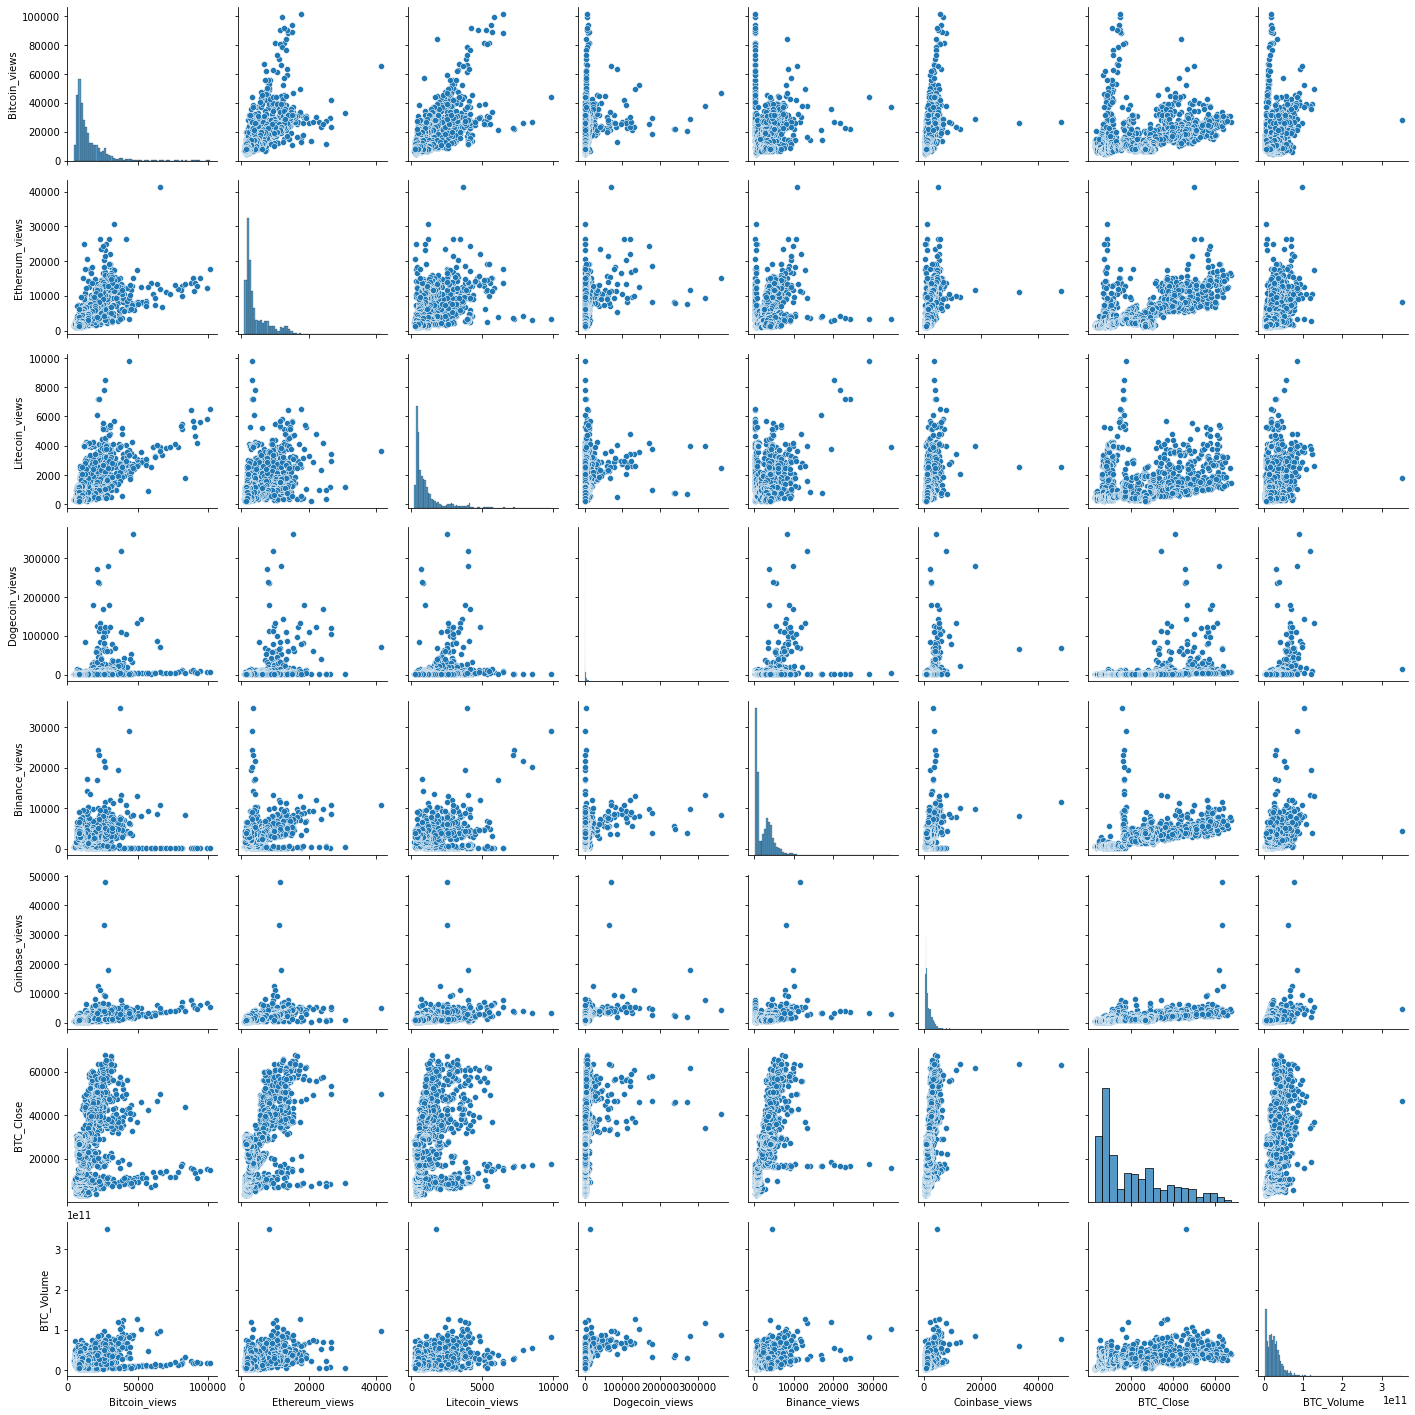

In [11]:
sns.pairplot(df)

Histograms are very skewed and so taking log of data may help to better normalize distributions and highlight relationships better. 

In [6]:
# Before taking log check if there are any zeroes in the DataFrame
if (df == 0).any().any():
    print("The DataFrame contains zeroes.")
else:
    print("The DataFrame has no zeroes.")

The DataFrame has no zeroes.


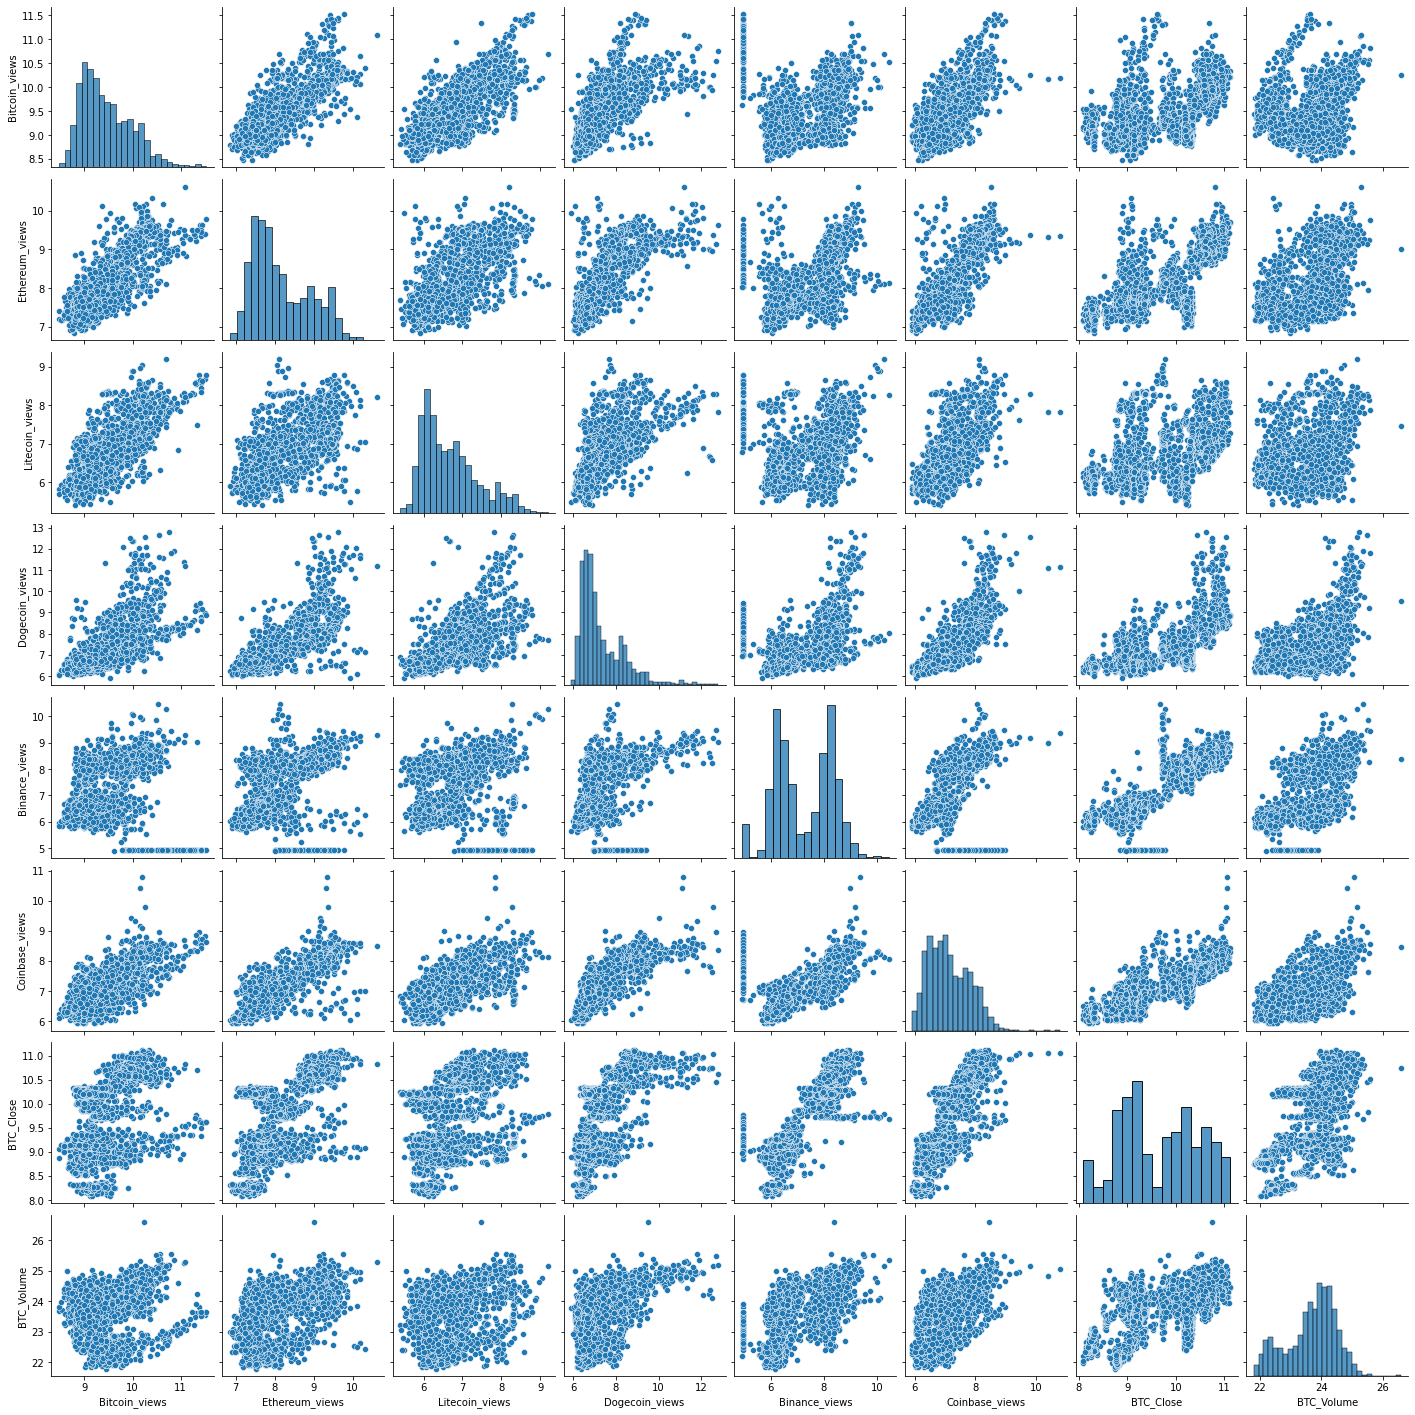

In [9]:
sns.pairplot(np.log(df.select_dtypes(include=['number'])))

Volume doesn't seem to have correlation with any of the variables. 

In [21]:
def create_shifted_columns(df, column_names, num_shifts=30):
    df_shifted= df.copy()
    for column_name in column_names:
        for i in range(1, num_shifts + 1):
            new_column_name = f"{column_name}_{i}"
            df_shifted[new_column_name] = df_shifted[column_name].shift(i)
    return df_shifted.copy()

In [43]:
df_shift=  create_shifted_columns(df,['BTC_Close','Ethereum_views','Litecoin_views','Dogecoin_views','Binance_views','Coinbase_views','BTC_Close','BTC_Volume'],num_shifts=30)

C:\Users\apsin\AppData\Local\Temp\ipykernel_11368\2288965619.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_shifted[new_column_name] = df_shifted[column_name].shift(i)


In [44]:
df_shift.head(3)

,date,Bitcoin_views,Ethereum_views,Litecoin_views,Dogecoin_views,Binance_views,Coinbase_views,BTC_Close,BTC_Volume,BTC_Close_1,...,BTC_Volume_21,BTC_Volume_22,BTC_Volume_23,BTC_Volume_24,BTC_Volume_25,BTC_Volume_26,BTC_Volume_27,BTC_Volume_28,BTC_Volume_29,BTC_Volume_30
0,2018-01-01,66949,6804,3340,4368,141,3660,13657.200195,1.029120e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,90271,11524,5256,6648,141,5535,14982.099609,1.684660e+10,13657.200195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,99223,12196,5850,7881,141,6699,15201.000000,1.687190e+10,14982.099609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df_shift.dropna(inplace=True)

In [46]:
X= df_shift.copy()
X.drop(columns=['date'], inplace=True)
y = X.pop("BTC_Close")


In [47]:
#https://www.kaggle.com/code/ryanholbrook/mutual-information
from sklearn.feature_selection import mutual_info_regression

discrete_features = X.dtypes == int


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores
#mi_scores[::3] 

BTC_Close_1          3.014633
BTC_Close_2          2.667699
BTC_Close_3          2.447036
BTC_Close_4          2.328565
BTC_Close_5          2.253805
                       ...   
Litecoin_views_6     0.484959
Litecoin_views_10    0.484709
Litecoin_views_2     0.483190
Litecoin_views_1     0.474712
Litecoin_views_9     0.471344
Name: MI Scores, Length: 217, dtype: float64

In [50]:
# https://www.kaggle.com/code/ryanholbrook/time-series-as-features

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

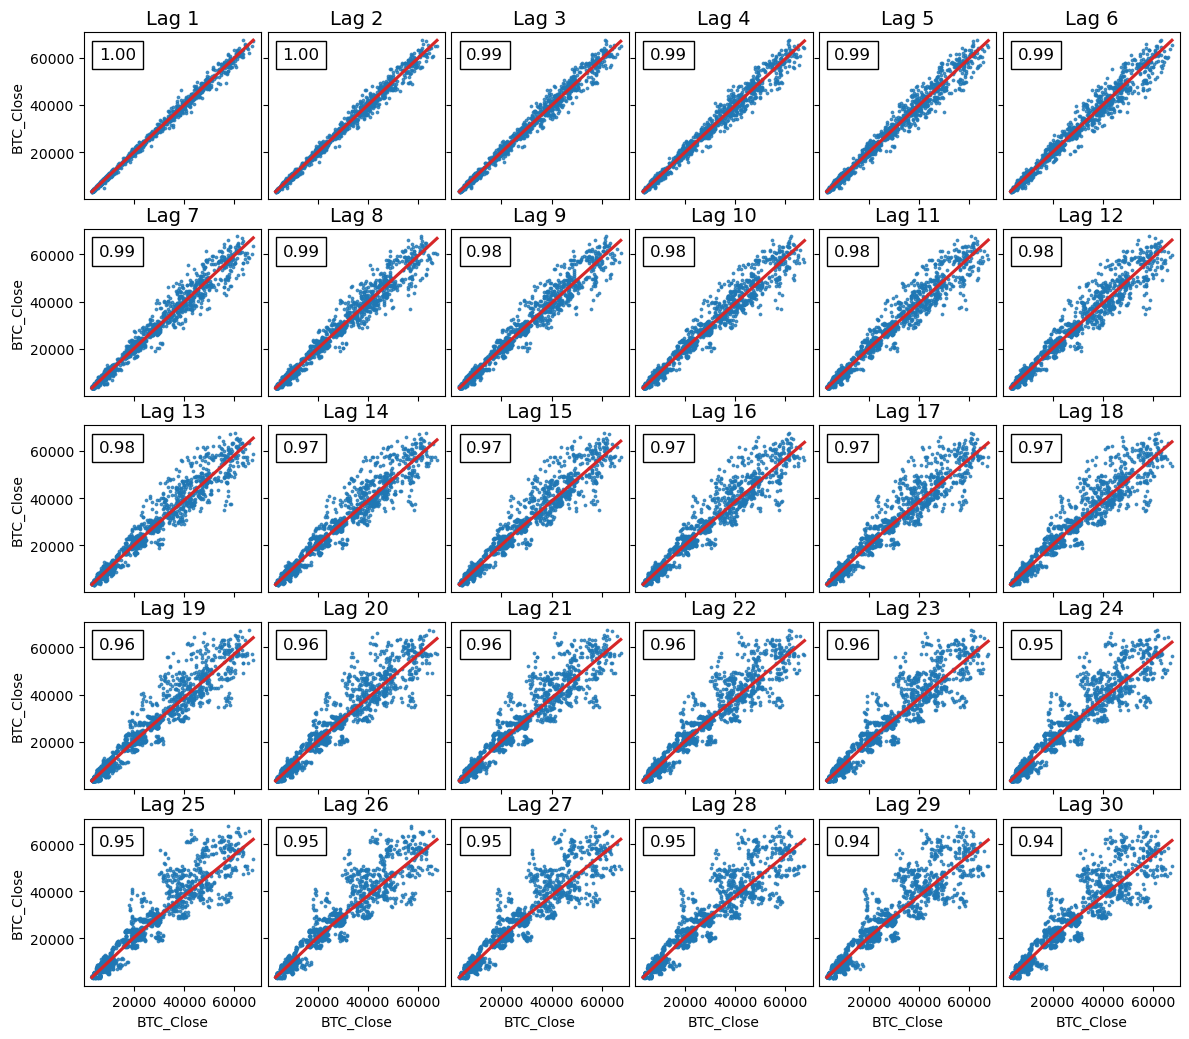

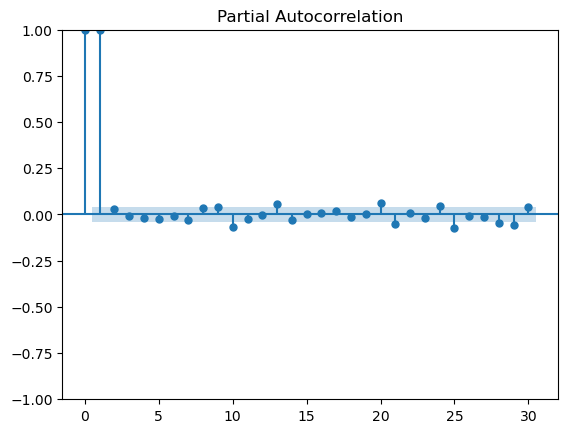

In [51]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
#from statsmodels.tsa.stattools import pacf

_ = plot_lags(df.BTC_Close, lags=30, nrows=5)
_= plot_pacf(df.BTC_Close, lags=30)

The lagplots suggest **linear relationship with lags**, while the partial Autocorrelation plot suggests that lags **1, 2, 11, 14, 21 contains useful information** for modeling. Lags 25 and 29 are likely false positives.

### Periodogram

In [15]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

In [14]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

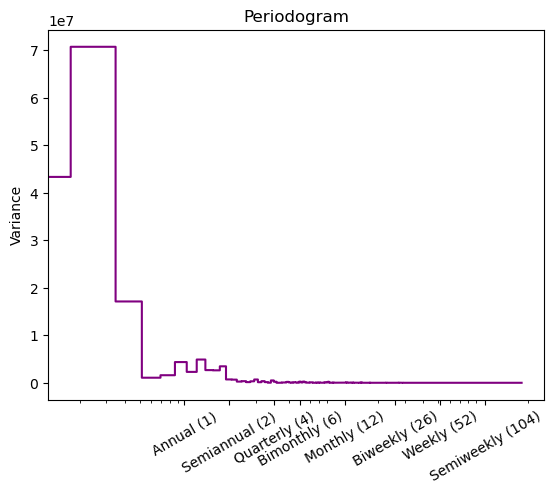

In [20]:
plot_periodogram(df.BTC_Close)


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

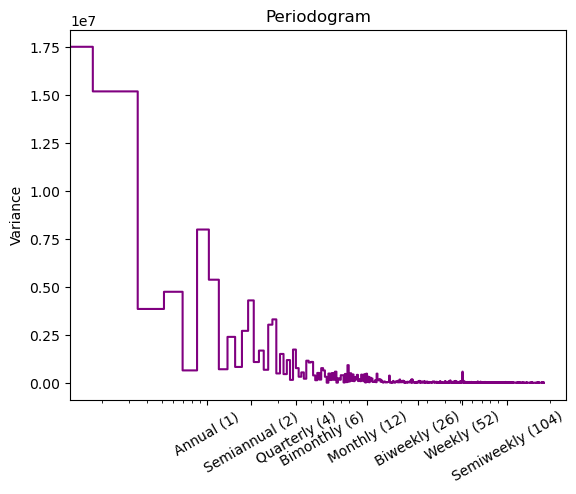

In [22]:
plot_periodogram(df.Bitcoin_views)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

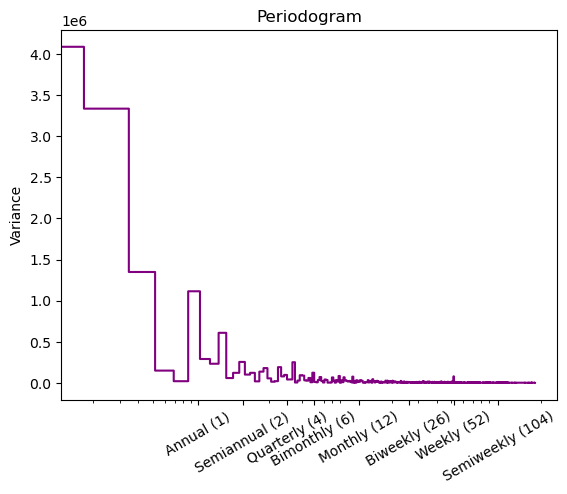

In [21]:
plot_periodogram(df.Ethereum_views)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

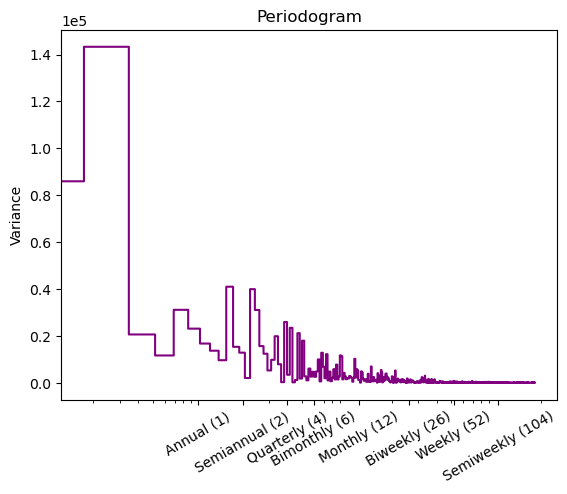

In [23]:
plot_periodogram(df.Litecoin_views)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

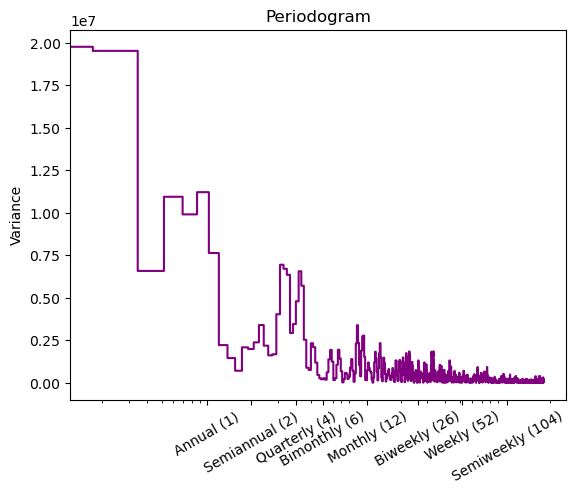

In [24]:
plot_periodogram(df.Dogecoin_views)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

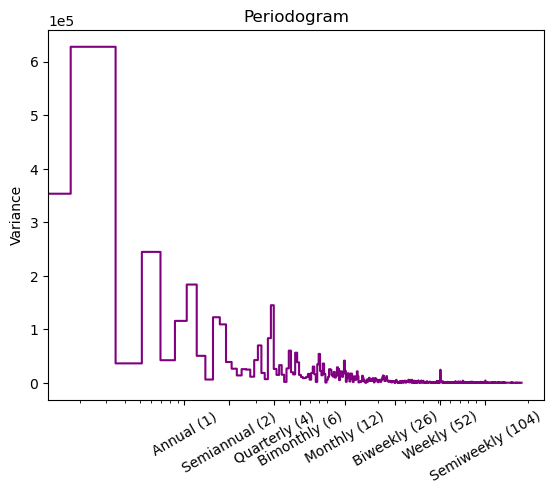

In [25]:

plot_periodogram(df.Binance_views)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

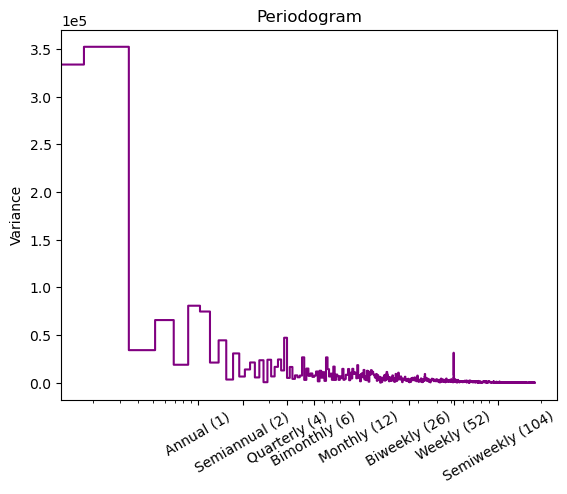

In [26]:
plot_periodogram(df.Coinbase_views)

In [ ]:
# days within a week
df["day"] = df['date'].to_period("D").dayofweek  # the x-axis (freq)
#df["week"] = df.date.week  # the seasonal period (period)